# Exploring the nitty-gritty of map projections to harmonize MetPy/proj4 and GEMPAK

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.constants as mpconst
from metpy.units import units
import numpy as np
import pint
from pyproj import Proj
import xarray as xr

GEMPAK calculations will be read in from text files originating from gdlist, so use Kevin's functions for that purpose as well as to compare GEMPAK and MetPy results later. 

In [3]:
def read_nam_gdlist(name):
    file = open(name, 'rb')

    for _ in range(6):
        file.readline()

    grid_row = file.readline()
    nlon = int(grid_row[-11:-5].strip())
    nlat = int(grid_row[-4:].strip())
    #print(nlon,nlat)

    gempak_array = np.empty((nlat, nlon))

    for _ in range(2):
        file.readline()

    scale_row = file.readline()
    scale_factor = int(scale_row[19:].strip())
    #print(scale_factor)

    for _ in range(79):
        file.readline()

    col = 0
    row = 0
    
    for line in file.readlines():
        if (line[:8].strip() != b'') & (col >= nlon):
            col = 0
            row+=1
        for count in [0,1,2,3,4,5,6,7]:
            if (line[8+count*9:17+count*9]) == '\n':
                gempak_array[row, col] = np.nan
            else:
                gempak_array[row, col] = line[8+count*9:17+count*9]
            col+=1
            if col >= nlon: break

    file.close()
    
    return (gempak_array, -scale_factor)

def error_stats(metpy_data, gempak_data):
    ignore = (gempak_data != -9999.0) * ~np.isnan(metpy_data)
    
    if isinstance(metpy_data.data, pint.Quantity):
        print(f'Is Xarray with Quantity? True')
        mdata = metpy_data.values[ignore]
    elif isinstance(metpy_data, pint.Quantity):
        print(f'Is Xarray with Quantity? False')
        print(f'Is Metpy Unit Array? True')
        mdata = metpy_data.m[ignore]
    else:
        print(f'Is Xarray with Quantity? False')
        print(f'Is Metpy Unit Array? False')
        print(f'I got back just a numpy array')
        try:
            mdata = metpy_data.values[ignore]
        except:
            mdata = metpy_data[ignore]
    gempak_data = gempak_data[ignore]
    
    print()
    print('Mean Comparison')
    print(f'  Mean Values (MetPy): {mdata.mean()}')
    print(f'  Mean Values (GEMPAK): {gempak_data.mean()}')
    print()
    print('Max Comparison')
    print(f'  Max Values (MetPy): {mdata.max()}')
    print(f'  Max Values (GEMPAK): {gempak_data.max()}')
    print()
    print('Min Comparison')
    print(f'  Min Values (MetPy): {mdata.min()}')
    print(f'  Min Values (GEMPAK): {gempak_data.min()}')

    print()
    print('Difference Array')
    diff = mdata - gempak_data
    print(diff)
    print()
    print('Various Statistical Analyses')
    print(f'  Average Absolute Difference: {np.nanmean(np.abs(diff))}')
    print(f'  RMS Error: {np.sqrt(np.nansum(diff**2))/len(diff.ravel())}')
    print(f'  Standard Deviation of Difference: {np.nanstd(diff)}')
    print(f'  Max Diff: {np.max(diff)}')
    print(f'  Min Diff: {np.min(diff)}')
    print(f'  Correlation: {np.corrcoef(mdata.ravel(), gempak_data.ravel())[0][1]}')
    print(f'  Relative Magnitude Difference: {np.nanmean(np.abs(diff))/np.nanmax(mdata)}')
    print()
    
def extract_gemdata(out_var, scale):
    return out_var[::-1, :] * 10**scale

## Case 1: Grid 218 (LCC)

### Map factor comparison

#### GEMPAK

The crux of the problem seems to be that GEMPAK's definition of "map factor" differs from proj4's, as they give different results when used in trial calculations. Let's verify this. First, here are the map factors from GEMPAK. (Note that this is a conformal grid, so the map factors at a given gridpoint should be the same in both x and y directions, but we check both to be complete.)

In [18]:
msfx_gem = extract_gemdata(*read_nam_gdlist('msfx218.txt'))
lat_gem = np.rad2deg(extract_gemdata(*read_nam_gdlist('latr218.txt')))
lon_gem = np.rad2deg(extract_gemdata(*read_nam_gdlist('lonr218.txt')))

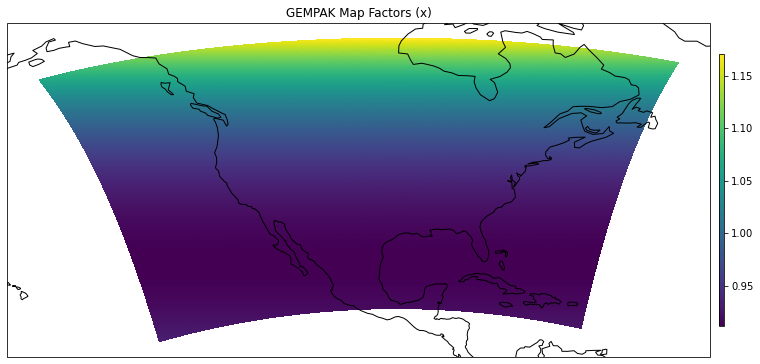

In [27]:
map_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": map_proj})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_gem, shading='auto')
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('GEMPAK Map Factors (x)')
plt.show()

In [28]:
# Verify y factors are the same
msfy_gem = extract_gemdata(*read_nam_gdlist('msfy218.txt'))
print('x and y factors are same?', np.all(msfx_gem == msfy_gem))

x and y factors are same? True


Grid 218 is an LCC projection with standard parallel 25 N and standard longitude 95 W. The map above shows that the map factors for this projection are a function of latitude only, which is in agreement with the underlying theory. Somewhat surprising (to me) is the next plot, which shows that, while the standard latitude is where the map factor is minimized, that minimum is not 1.

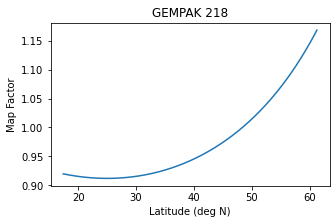

In [38]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,300],msfx_gem[:,300])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('GEMPAK 218')
plt.show()

Now let's see what proj4 produces. To get as close to GEMPAK as possible, we assume a spherical Earth with the radius as used by GEMPAK, then set up the corresponding Cartopy projection.

In [40]:
earth_radius = 6371200
earth_sphere = ccrs.Globe(ellipse=None, semimajor_axis=earth_radius)

In [45]:
lcc_proj = ccrs.LambertConformal(globe=earth_sphere, 
                                 standard_parallels=(25,25),
                                 central_longitude=-95, central_latitude=25)

One issue: GEMPAK does not state a central latitude. The proj4 parameters in Kevin's notebook give 25N for that as well, so we included that above.

Let's see if the GEMPAK data is rectangular on this projection.

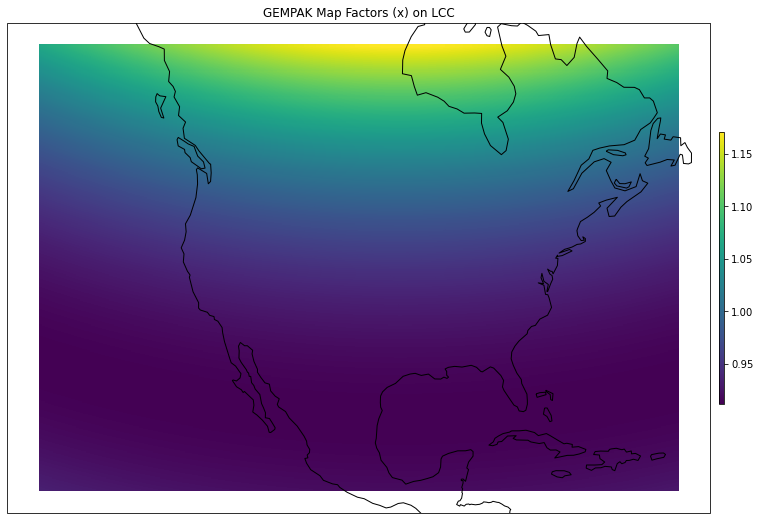

In [49]:
fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": lcc_proj})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_gem, shading='auto', transform=map_proj)
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('GEMPAK Map Factors (x) on LCC')
plt.show()

Looks good, but what do the proj4 map factors look like?

#### proj4

In [51]:
lcc_proj.proj4_params

{'a': 6371200,
 'proj': 'lcc',
 'lon_0': -95,
 'lat_0': 25,
 'x_0': 0.0,
 'y_0': 0.0,
 'lat_1': 25,
 'lat_2': 25}

In [54]:
factors = Proj(projparams=lcc_proj.proj4_params).get_factors(lon_gem, lat_gem)

In [68]:
msfx_p4 = factors.parallel_scale
msfy_p4 = factors.meridional_scale
print('proj4 x and y factors the same?', np.all(msfx_p4 == msfy_p4))

proj4 x and y factors the same? False


In [69]:
error_stats(msfx_p4, msfy_p4)

Is Xarray with Quantity? False
Is Metpy Unit Array? False
I got back just a numpy array

Mean Comparison
  Mean Values (MetPy): 1.064650454406276
  Mean Values (GEMPAK): 1.0646504544396156

Max Comparison
  Max Values (MetPy): 1.2836348932152322
  Max Values (GEMPAK): 1.283634893356647

Min Comparison
  Min Values (MetPy): 0.9999999999943233
  Min Values (GEMPAK): 1.000000000002675

Difference Array
[-2.70137246e-11  1.34872113e-11  3.81250587e-13 ... -9.70243885e-11
 -7.36168904e-11 -5.97910610e-11]

Various Statistical Analyses
  Average Absolute Difference: 3.514540758898182e-11
  RMS Error: 8.687414804690403e-14
  Standard Deviation of Difference: 2.952624603627866e-11
  Max Diff: 5.146705284175823e-11
  Min Diff: -1.4952550309033086e-10
  Correlation: 1.0
  Relative Magnitude Difference: 2.7379598182276002e-11



OK, the proj4 factors only differ in the 10th decimal place at most; this is likely round-off error. (Presumably GEMPAK uses theory to make its x and y factors identical.) We will stick to the x-factors only for further comparisons. Here's the plots:

/home/decker/local/miniconda3/envs/metpy21/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


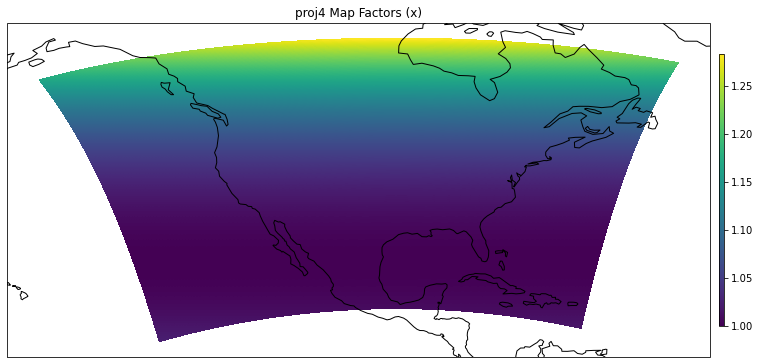

In [70]:
fig, ax = plt.subplots(figsize=(15,10),
                       subplot_kw={"projection": map_proj})
cf = ax.pcolormesh(lon_gem, lat_gem, msfx_p4, shading='auto')
plt.colorbar(cf, orientation='vertical', pad=.01, aspect=50, shrink=.5)
ax.coastlines()
plt.title('proj4 Map Factors (x)')
plt.show()

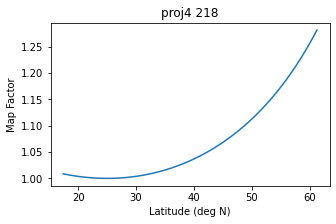

In [71]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,300],msfx_p4[:,300])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('proj4 218')
plt.show()

So the shape is the same, but the values are different. Is the difference constant?

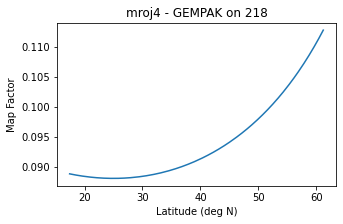

In [72]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,300],msfx_p4[:,300]-msfx_gem[:,300])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('proj4 - GEMPAK on 218')
plt.show()

Not quite. Looking at https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID218 perhaps the central latitude should be 35 N for this grid? Let's try that instead and see!

In [73]:
lcc_proj2 = ccrs.LambertConformal(globe=earth_sphere, 
                                  standard_parallels=(25,25),
                                  central_longitude=-95, central_latitude=35)

In [75]:
factors2 = Proj(projparams=lcc_proj2.proj4_params).get_factors(lon_gem, lat_gem)
msfx_p42 = factors2.parallel_scale

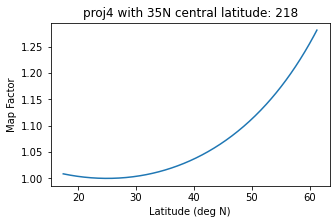

In [76]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,300],msfx_p42[:,300])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('proj4 with 35N central latitude: 218')
plt.show()

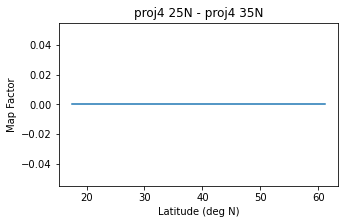

In [79]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(lat_gem[:,300],msfx_p4[:,300]-msfx_p42[:,300])
ax.set_ylabel('Map Factor')
ax.set_xlabel('Latitude (deg N)')
plt.title('proj4 25N - proj4 35N')
plt.show()

It appears the central latitude has no impact on the map factors (presumably it just shifts the entire map up or down). So why the discrepancy? The proj4 results match my intuition (map factor is 1 at the standard parallel), so is GEMPAK just wrong here?

The investigation continues...